In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import *
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [3]:
df = pd.read_excel('вар_5_эко_1.xlsx')
df

,T,HHI_Q
0,1993 I,13.8
1,II,26.1
2,III,50.0
3,IV,89.3
4,1994 I,116.9
...,...,...
111,IV,42968.6
112,2021 I,32611.6
113,II,37866.0
114,III,40402.0


In [10]:
df['T'] = pd.period_range(start='1/1/1993', end='31/12/2021', freq='Q')
df = df.set_index(['T'])
df.index = df.index.to_timestamp()
df.head(10)

C:\Users\Admin\AppData\Local\Temp\ipykernel_16532\2256829121.py:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['T'] = pd.period_range(start='1/1/1993', end='31/12/2021', freq='Q')


,HHI_Q
T,
1993-01-01,13.8
1993-04-01,26.1
1993-07-01,50.0
1993-10-01,89.3
1994-01-01,116.9
1994-04-01,168.9
1994-07-01,223.2
1994-10-01,316.4
1995-01-01,351.6


<Axes: xlabel='T'>

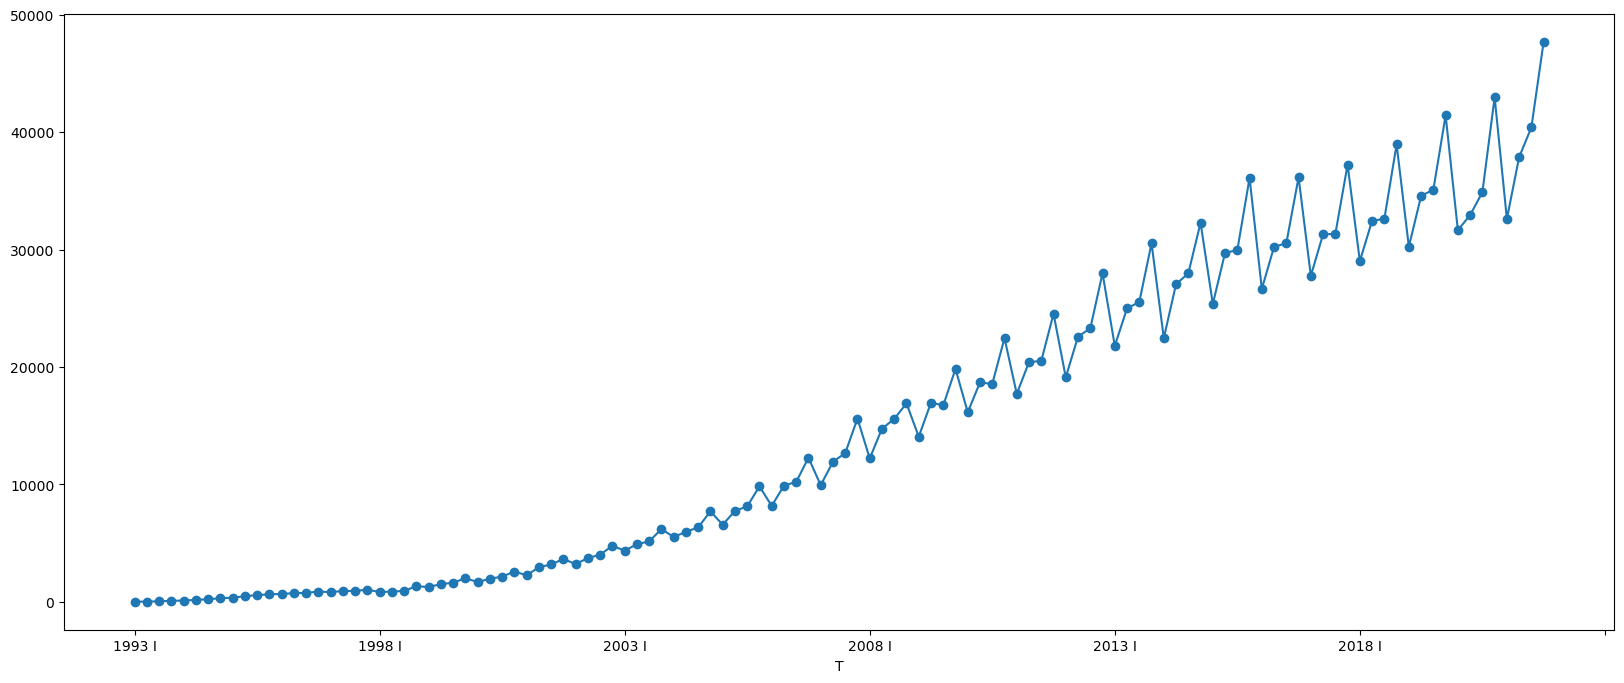

In [3]:
df.set_index('T')['HHI_Q'].plot(figsize = (20,8), marker = 'o')

In [1]:
# Тренд + сезонность

<Axes: >

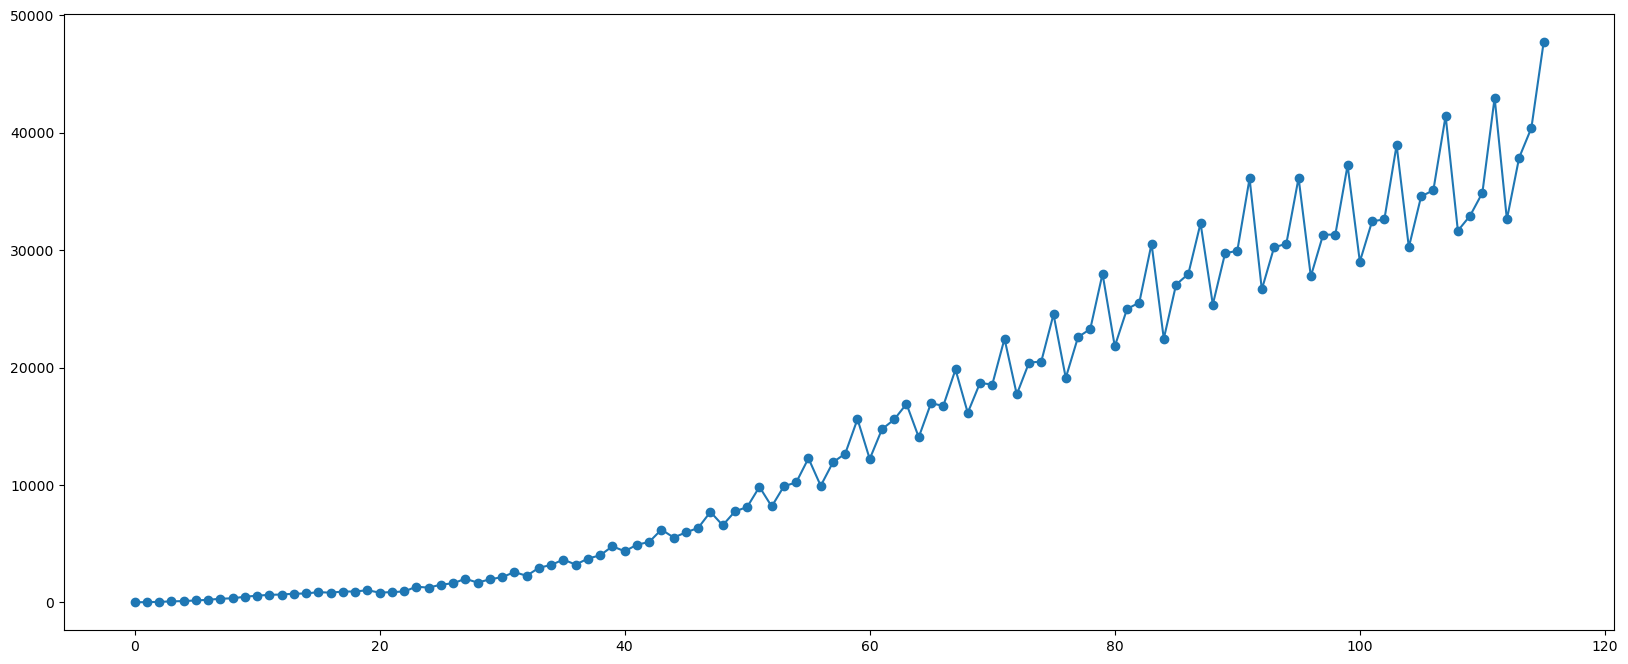

In [4]:
df['HHI_Q'].plot(figsize = (20, 8), marker = 'o')

In [5]:
model = ExponentialSmoothing(np.asarray(df['HHI_Q']), trend ='add', seasonal =
'add', seasonal_periods=4)
fit = model.fit()
forecast = fit.forecast(steps = len(df))
print(fit.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    endog   No. Observations:                  116
Model:             ExponentialSmoothing   SSE                       57481908.205
Optimized:                         True   AIC                           1537.153
Trend:                         Additive   BIC                           1559.182
Seasonal:                      Additive   AICC                          1539.249
Seasonal Periods:                     4   Date:                 Thu, 09 Nov 2023
Box-Cox:                          False   Time:                         11:32:28
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.4911367                alpha                 True
smoothing_trend          

In [11]:
df

,HHI_Q
T,
1993-01-01,13.8
1993-04-01,26.1
1993-07-01,50.0
1993-10-01,89.3
1994-01-01,116.9
...,...
2020-10-01,42968.6
2021-01-01,32611.6
2021-04-01,37866.0


In [13]:
forecast_errors = df - forecast
stderr = np.std(forecast_errors)
z_score = 1.96
lower_bounds, upper_bounds = [], []
for i in range(len(forecast)):
 lower = forecast[i] - (z_score * stderr)
 upper = forecast[i] + (z_score * stderr)
 lower_bounds.append(lower)
 upper_bounds.append(upper)
confidence_interval = pd.DataFrame({'Нижняя граница': lower_bounds, 
'Верхняя граница': upper_bounds}, index=df.index)
plt.figure(figsize=(10,6))
plt.plot(df.index, df, label='Реальные значения', marker='o', color =
'hotpink')
plt.plot(df.index, forecast, label='Прогноз', marker='o', color =
'navy')
plt.ylabel('Индекс выпуска по БВЭД')
plt.legend()
plt.grid()
plt.show()

ValueError: Unable to coerce to Series, length must be 1: given 116

# Выбросы

<Axes: >

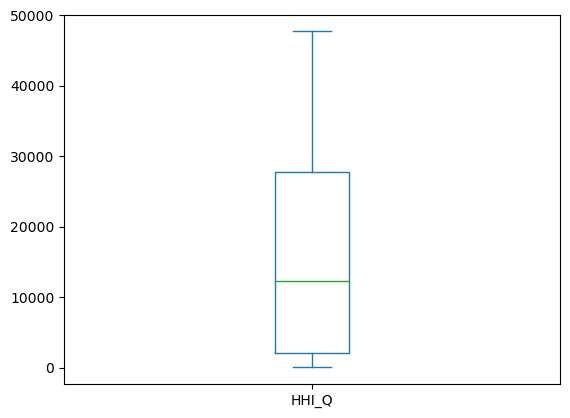

In [5]:
df['HHI_Q'].plot(kind = 'box')

In [6]:
# Выбросов нет

Аномальные значения на основе распределения Стьюдента

In [7]:
y = df['HHI_Q']
n = df.shape[0]

In [8]:
S_y = np.std(y)
S_y

13421.793790607468

In [9]:
t_hat = (y - y.mean())/S_y
t_hat

0     -1.132589
1     -1.131672
2     -1.129891
3     -1.126963
4     -1.124907
         ...   
111    2.067788
112    1.296133
113    1.687616
114    1.876562
115    2.419858
Name: HHI_Q, Length: 116, dtype: float64

In [10]:
T_1 = t(n-2)
t_1 = T_1.isf(0.05/2);t_1

1.9809922979375068

In [11]:
t_2 = T_1.isf(0.001/2);t_2

3.3779224543702067

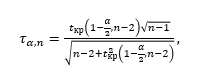

In [12]:
tau_1 = (t_1*np.sqrt(n-1))/np.sqrt(n-2 + t_1**2)
tau_2 = (t_2*np.sqrt(n-1))/np.sqrt(n-2 + t_2**2)
tau_1, tau_2

(1.956275417280304, 3.2346842070658726)

In [13]:
t_hat <= tau_1

0       True
1       True
2       True
3       True
4       True
       ...  
111    False
112     True
113     True
114     True
115    False
Name: HHI_Q, Length: 116, dtype: bool

In [14]:
# подозрительные значения

In [15]:
df.iloc[111]

T             IV
HHI_Q    42968.6
Name: 111, dtype: object

In [16]:
df.iloc[115]

T             IV
HHI_Q    47694.0
Name: 115, dtype: object

In [17]:
sum(t_hat > tau_2)

0

Метод Ирвина

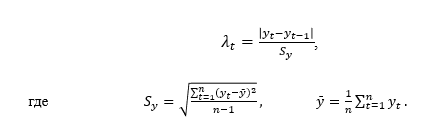

In [18]:
S_y = np.sqrt(sum((y - y.mean())**2)/(n-1))
S_y

13480.023104315234

In [19]:
abs(df['HHI_Q'].iloc[111] - df['HHI_Q'].iloc[110])/S_y

0.6004292379446295

In [20]:
abs(df['HHI_Q'].iloc[115] - df['HHI_Q'].iloc[114])/S_y

0.5409486277264376

In [21]:
# значения не являются аномальными

# Выявление наличия тренда

In [71]:
# критерий серий, основанный на медиане

In [72]:
y_rang = sorted(df['HHI_Q'])
y_rang

[13.8,
 26.1,
 50.0,
 89.3,
 116.9,
 168.9,
 223.2,
 316.4,
 351.6,
 485.4,
 575.6,
 646.9,
 674.9,
 743.0,
 761.5,
 829.4,
 835.1,
 880.7,
 881.0,
 929.5,
 929.9,
 932.7,
 1042.2,
 1259.1,
 1341.4,
 1514.7,
 1632.5,
 1688.1,
 1970.0,
 2015.6,
 2152.2,
 2267.5,
 2582.9,
 2950.4,
 3193.2,
 3219.7,
 3649.6,
 3735.2,
 4012.3,
 4353.9,
 4785.1,
 4916.8,
 5147.8,
 5526.2,
 5964.2,
 6204.8,
 6345.3,
 6567.8,
 7711.2,
 7748.6,
 8129.5,
 8171.5,
 9841.2,
 9899.4,
 9930.9,
 10217.7,
 11932.5,
 12213.0,
 12274.3,
 12667.1,
 14065.1,
 14749.7,
 15579.3,
 15605.9,
 16146.4,
 16730.6,
 16904.5,
 16967.9,
 17710.6,
 18549.4,
 18690.0,
 19121.0,
 19833.3,
 20417.6,
 20512.3,
 21800.0,
 22456.0,
 22457.1,
 22591.0,
 23280.7,
 24535.0,
 24990.4,
 25364.0,
 25528.7,
 26646.2,
 27059.3,
 27763.0,
 27964.6,
 27986.2,
 29011.2,
 29723.1,
 29945.5,
 30234.0,
 30240.8,
 30532.9,
 30539.5,
 31306.6,
 31325.0,
 31646.6,
 32285.0,
 32455.0,
 32609.2,
 32611.6,
 32932.2,
 34569.1,
 34874.8,
 35096.9,
 36099.8,
 

In [80]:
me = [y_rang[0]]
for i in range(len(y_rang)-1):
    me.append(round((y_rang[i] + y_rang[i+1])/2, 3))
me

[13.8,
 19.95,
 38.05,
 69.65,
 103.1,
 142.9,
 196.05,
 269.8,
 334.0,
 418.5,
 530.5,
 611.25,
 660.9,
 708.95,
 752.25,
 795.45,
 832.25,
 857.9,
 880.85,
 905.25,
 929.7,
 931.3,
 987.45,
 1150.65,
 1300.25,
 1428.05,
 1573.6,
 1660.3,
 1829.05,
 1992.8,
 2083.9,
 2209.85,
 2425.2,
 2766.65,
 3071.8,
 3206.45,
 3434.65,
 3692.4,
 3873.75,
 4183.1,
 4569.5,
 4850.95,
 5032.3,
 5337.0,
 5745.2,
 6084.5,
 6275.05,
 6456.55,
 7139.5,
 7729.9,
 7939.05,
 8150.5,
 9006.35,
 9870.3,
 9915.15,
 10074.3,
 11075.1,
 12072.75,
 12243.65,
 12470.7,
 13366.1,
 14407.4,
 15164.5,
 15592.6,
 15876.15,
 16438.5,
 16817.55,
 16936.2,
 17339.25,
 18130.0,
 18619.7,
 18905.5,
 19477.15,
 20125.45,
 20464.95,
 21156.15,
 22128.0,
 22456.55,
 22524.05,
 22935.85,
 23907.85,
 24762.7,
 25177.2,
 25446.35,
 26087.45,
 26852.75,
 27411.15,
 27863.8,
 27975.4,
 28498.7,
 29367.15,
 29834.3,
 30089.75,
 30237.4,
 30386.85,
 30536.2,
 30923.05,
 31315.8,
 31485.8,
 31965.8,
 32370.0,
 32532.1,
 32610.4,
 327

In [92]:
med = pd.DataFrame({'med': me, 'y_rang': y_rang})
med = med.iloc[1:]
med['sign'] = np.where(med['med'] <med['y_rang'], '+', '-')
med

,med,y_rang,sign
1,19.95,26.1,+
2,38.05,50.0,+
3,69.65,89.3,+
4,103.10,116.9,+
5,142.90,168.9,+
...,...,...,...
111,38405.50,38945.0,+
112,39673.50,40402.0,+
113,40915.15,41428.3,+
114,42198.45,42968.6,+


In [93]:
med['sign'].values

array(['+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+',
       '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+',
       '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+',
       '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+',
       '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+',
       '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+',
       '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+',
       '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+',
       '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+'],
      dtype=object)

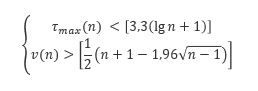

In [98]:
med['sign'].value_counts()

+    115
Name: sign, dtype: int64

In [13]:
tilda = 115
print(3.3*np.log(117))
v = 1
print(0.5*(117 - 1/96*np.sqrt(115)))
# есть тренд

15.715173984832594
58.444146847423106


# Сглаживание

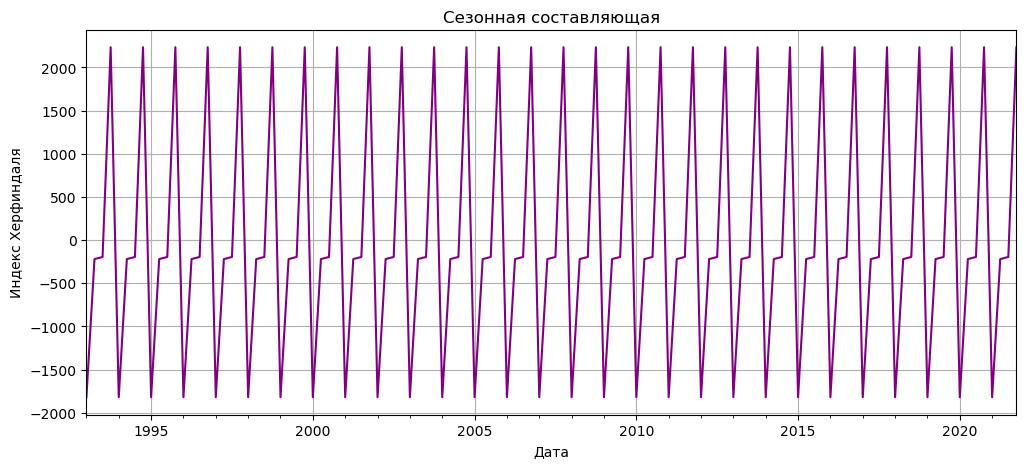

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose

res = seasonal_decompose(df)
res.seasonal.plot(figsize=(12,5), color='purple')
plt.title('Сезонная составляющая')
plt.ylabel('Индекс Херфиндаля')
plt.xlabel('Дата')
plt.grid()
plt.show()

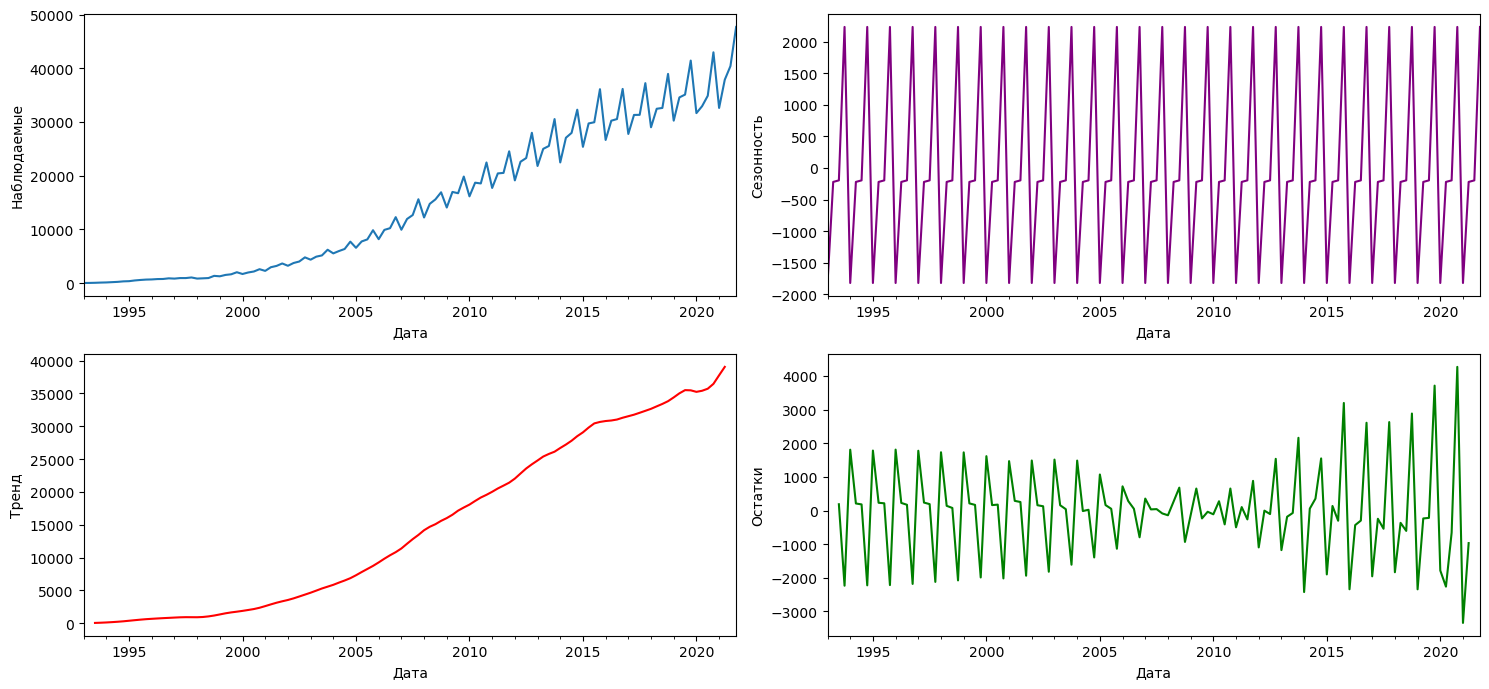

In [103]:
result = seasonal_decompose(df)
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(15,7))

res.observed.plot(ax=axes[0][0])
axes[0][0].set_ylabel('Наблюдаемые')
axes[0][0].set_xlabel('Дата')

res.trend.plot(ax=axes[1][0], color='red')
axes[1][0].set_ylabel('Тренд')
axes[1][0].set_xlabel('Дата')

res.seasonal.plot(ax=axes[0][1], color='purple')
axes[0][1].set_ylabel('Сезонность')
axes[0][1].set_xlabel('Дата')

res.resid.plot(ax=axes[1][1], color='green')
axes[1][1].set_ylabel('Остатки')
axes[1][1].set_xlabel('Дата')

plt.tight_layout()
plt.show()

Теперь выберем кривую роста

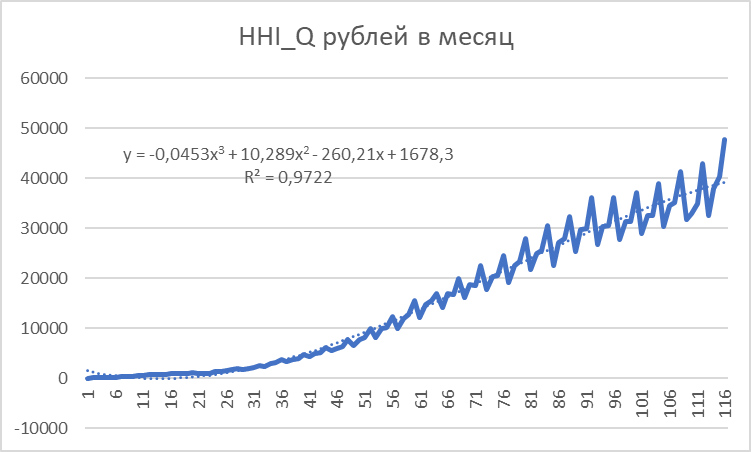

# Прогнозирование с помощью кривой роста

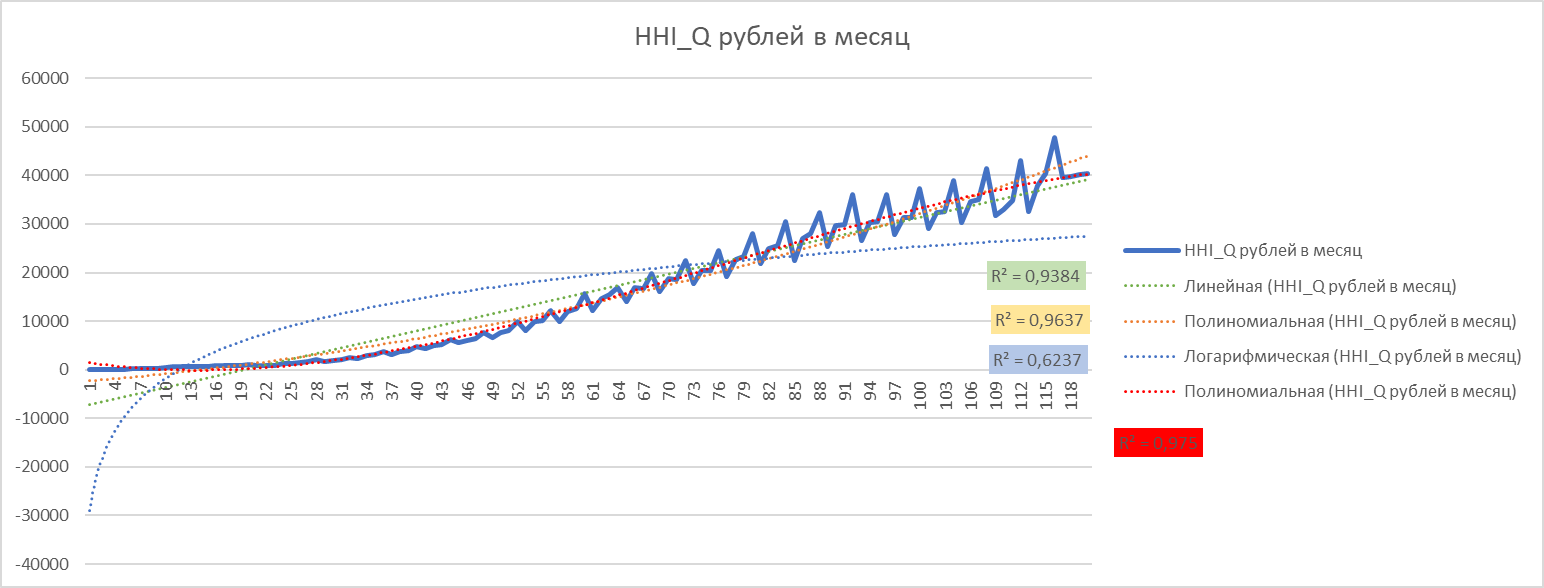

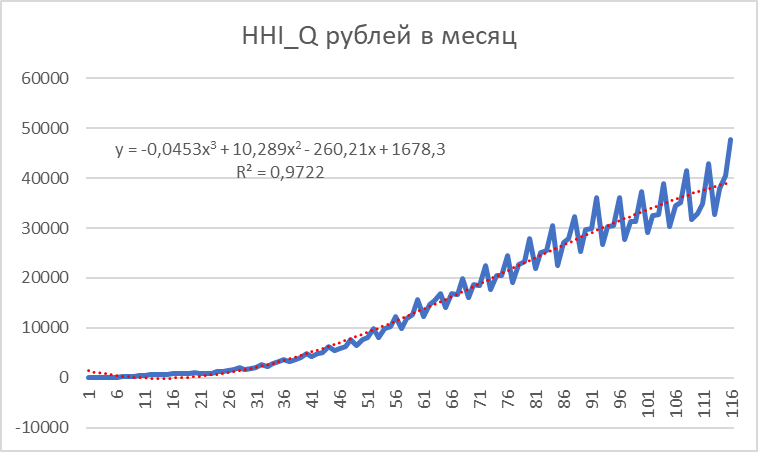

In [1]:
# Точечный прогноз

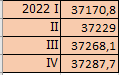

In [2]:
# Интервальный прогноз

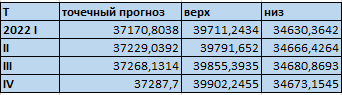

# Прогнозирование с применением адаптивной модели прогнозированя Брауна

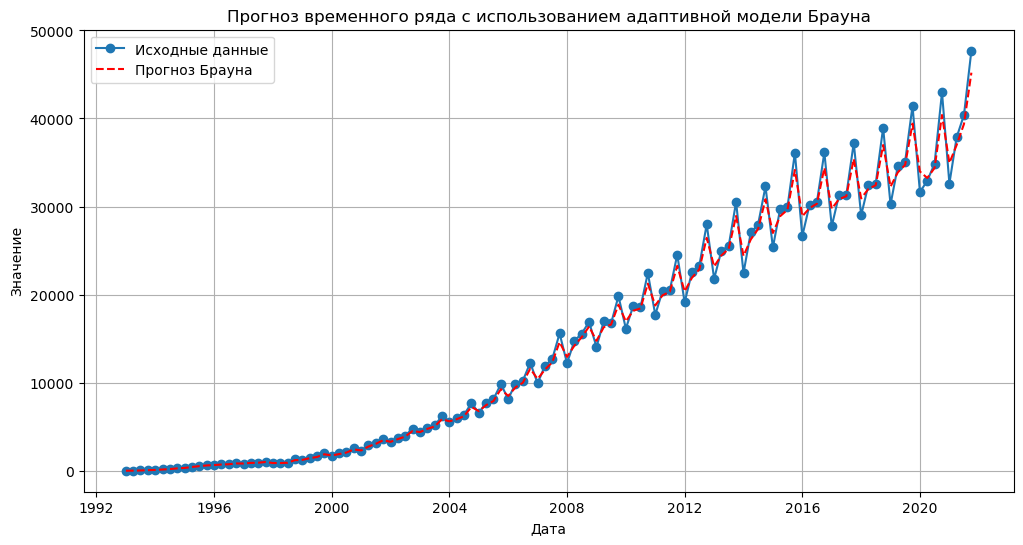

In [7]:
forecasts = [df['HHI_Q'].iloc[0]]

# Начальное значение коэффициента сглаживания
alpha = 0.7

# Адаптивное прогнозирование Брауна
for i in range(1, len(df)):
    # Рассчитайте новое значение прогноза
    forecast = alpha * df['HHI_Q'].iloc[i] + (1 - alpha) * forecasts[-1]
    forecasts.append(forecast)

df['Forecast'] = forecasts

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['HHI_Q'], label='Исходные данные', marker='o')
plt.plot(df.index, df['Forecast'], label='Прогноз Брауна', linestyle='--', color='red')
plt.title('Прогноз временного ряда с использованием адаптивной модели Брауна')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.grid()
plt.show()

# Моделирование тренд-сезонных процессов. Применить Модель Хольта-Уинтерса

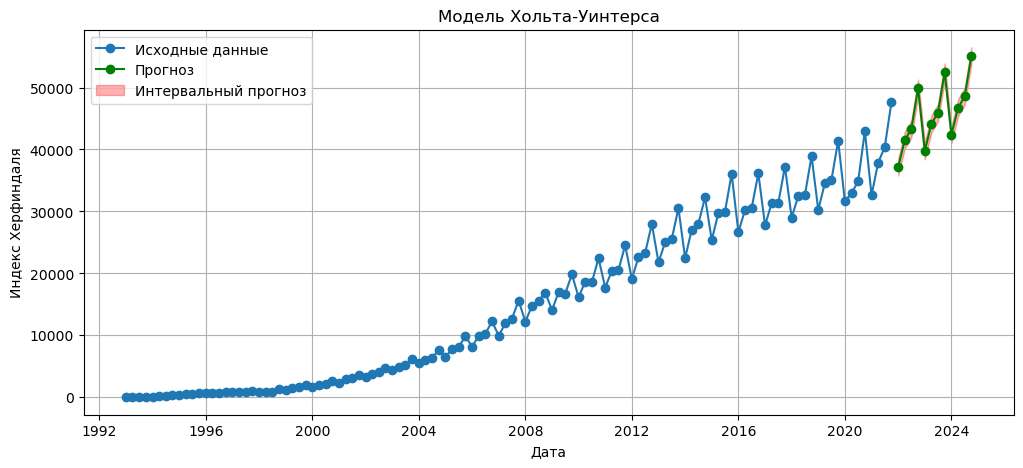

In [38]:
model = ExponentialSmoothing(df['HHI_Q'], trend='add', seasonal='add', seasonal_periods=4)
model_fit = model.fit()

forecast = model_fit.forecast(12)

# Интервальный прогноз
forecast_error = model_fit.resid.std()
confidence_level = 0.95
z_alpha = norm.ppf((1 + confidence_level) / 2)
lower_bound = forecast - z_alpha * forecast_error
upper_bound = forecast + z_alpha * forecast_error
forecast_intervals = pd.DataFrame({'Нижняя граница': lower_bound, 'Верхняя граница': upper_bound})

plt.figure(figsize=(12, 5))
plt.plot(df.index, df['HHI_Q'], label='Исходные данные', marker='o', linestyle='-')
plt.plot(forecast.index, forecast, label='Прогноз', marker='o', color='green')
plt.fill_between(forecast_intervals.index, forecast_intervals['Нижняя граница'], forecast_intervals['Верхняя граница'], color='red', alpha=0.3, label='Интервальный прогноз')
plt.title('Модель Хольта-Уинтерса')
plt.xlabel('Дата')
plt.ylabel('Индекс Херфиндаля')
plt.legend()
plt.grid()
plt.show()

 # 5. Выделение компонент тренд-сезонного временного ряда. Метод Четверикова: По заданным значениям временного ряда y_t выделить компоненты временного ряда: тренд f_t, сезонную компоненту S_t и остаточную последовательность ε_t.

In [28]:
result = seasonal_decompose(df['HHI_Q'], model='additive', period=4)

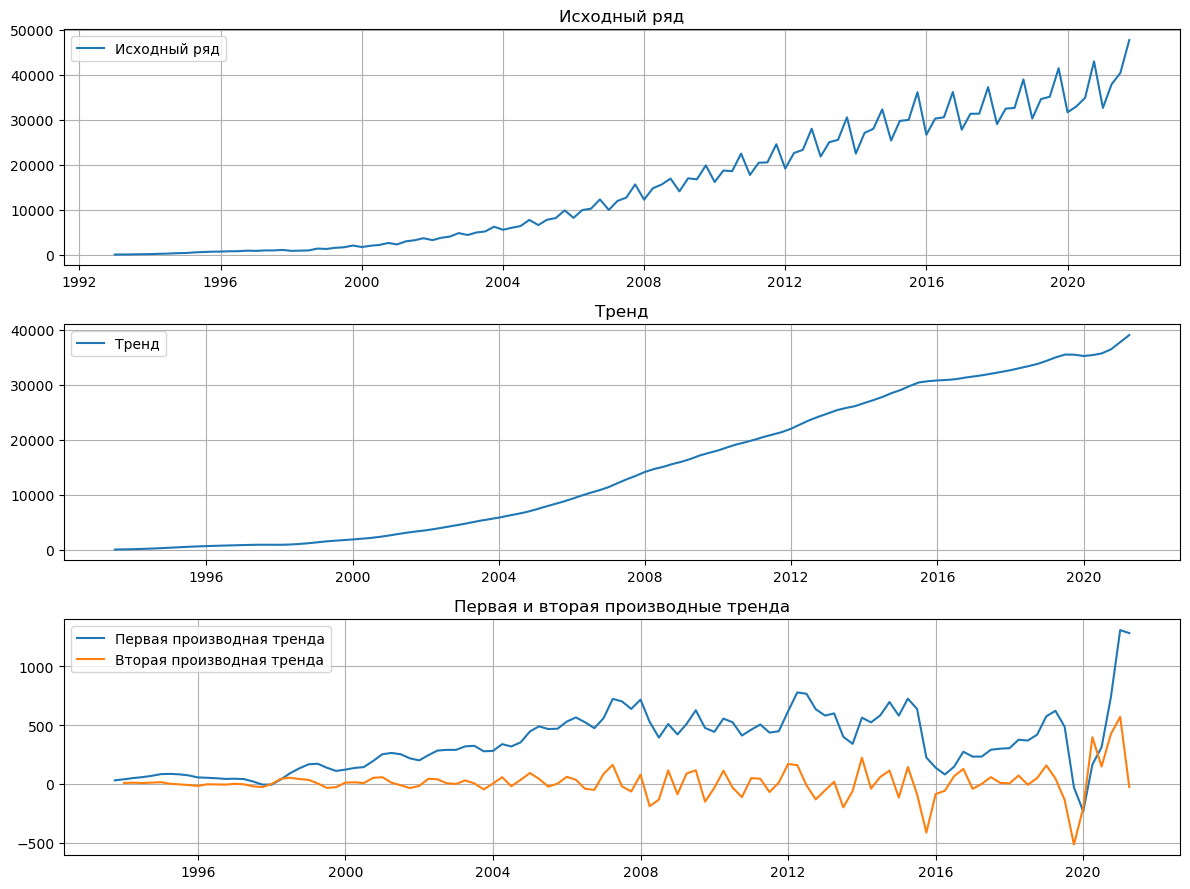

In [29]:
plt.figure(figsize=(12, 9))
plt.subplot(311)
plt.plot(df.index, df['HHI_Q'], label='Исходный ряд')
plt.title('Исходный ряд')
plt.legend(loc='upper left')
plt.grid()

plt.subplot(312)
plt.plot(df.index, result.trend, label='Тренд')
plt.title('Тренд')
plt.legend()
plt.grid()

plt.subplot(313)
plt.plot(df.index, result.trend.diff(), label='Первая производная тренда')
plt.plot(df.index, result.trend.diff().diff(), label='Вторая производная тренда')
plt.title('Первая и вторая производные тренда')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

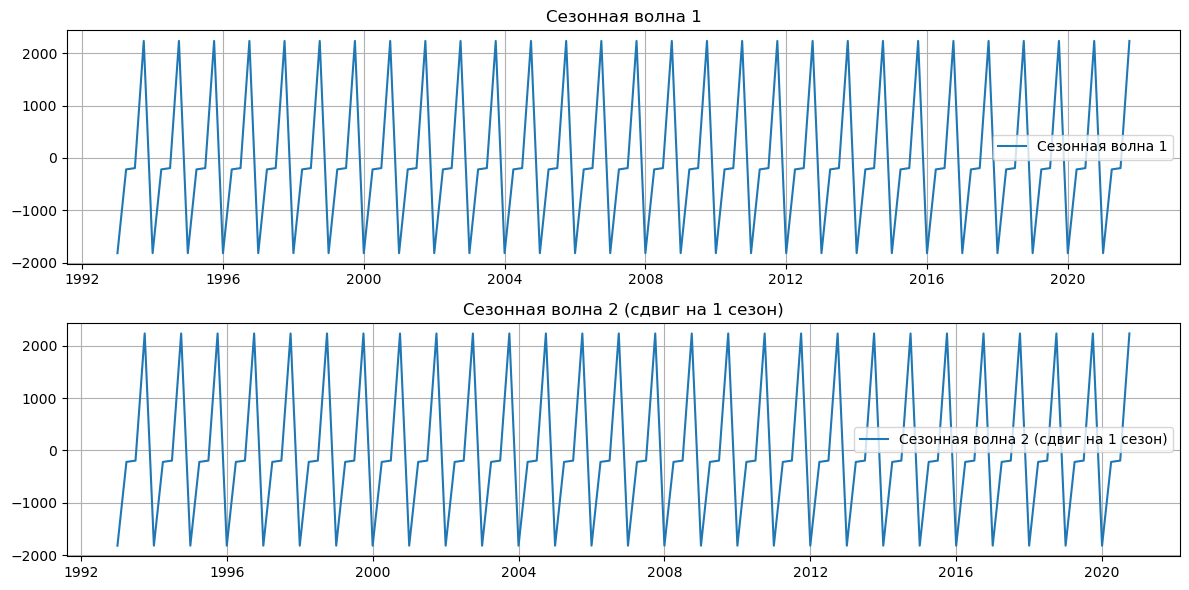

In [30]:
plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.plot(df.index, result.seasonal, label='Сезонная волна 1')
plt.title('Сезонная волна 1')
plt.legend()
plt.grid()

plt.subplot(212)
plt.plot(df.index, result.seasonal.shift(-4), label='Сезонная волна 2 (сдвиг на 1 сезон)')
plt.title('Сезонная волна 2 (сдвиг на 1 сезон)')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

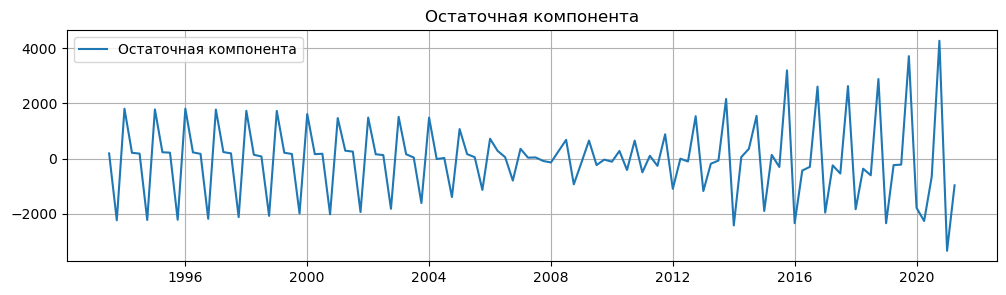

In [31]:
plt.figure(figsize=(12, 3))
plt.plot(df.index, result.resid, label='Остаточная компонента')
plt.title('Остаточная компонента')
plt.legend()
plt.grid()
plt.show()
